<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/06S_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация легких на рентгеновских снимках груди

Источник: Illia Ovcharenko github: <a href='https://github.com/IlliaOvcharenko/lung-segmentation'>link</a>

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/ml/dataset.tar.gz

--2022-12-08 14:38:16--  https://kodomo.fbb.msu.ru/FBB/ml/dataset.tar.gz
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4397905467 (4.1G) [application/x-gzip]
Saving to: ‘dataset.tar.gz’

dataset.tar.gz      100%[===================>]   4.10G  9.25MB/s    in 33m 16s 

2022-12-08 15:11:32 (2.10 MB/s) - ‘dataset.tar.gz’ saved [4397905467/4397905467]



In [ ]:
%%time
!tar -xzf dataset.tar.gz

CPU times: user 220 ms, sys: 41.3 ms, total: 261 ms
Wall time: 36.7 s


In [ ]:
%%shell
mkdir -p ./models
mkdir -p ./images
mkdir -p ./src

wget https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/data/scripts/data.py -O ./src/data.py
wget https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/data/scripts/metrics.py -O ./src/metrics.py
wget https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/data/scripts/models.py -O ./src/models.py
wget https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/data/splits.pk -O ./splits.pk

--2022-12-08 15:13:05--  https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/data/scripts/data.py
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3391 (3.3K) [application/octet-stream]
Saving to: ‘./src/data.py’

./src/data.py       100%[===================>]   3.31K  --.-KB/s    in 0s      

2022-12-08 15:13:05 (738 MB/s) - ‘./src/data.py’ saved [3391/3391]

--2022-12-08 15:13:05--  https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/data/scripts/metrics.py
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 902 [application/octet-stream]
Saving to: ‘./src/metrics.py’

./src/metrics.py    100%[===================>]     902  --.-KB/s    in 0s      

2022-12-08 15:13:05 (236

In [ ]:
import torch
import torchvision
import os
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
data_folder = Path("dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("models")
images_folder = Path("images")

In [ ]:
batch_size = 4

## Загрузим данные

In [ ]:
origins_list = [f.stem for f in origins_folder.glob("*.png")]
masks_list = [f.stem for f in masks_folder.glob("*.png")]

print(f"images: {len(origins_list)}")
print(f"masks: {len(masks_list)}")

images: 800
masks: 704


In [ ]:
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

In [ ]:
split_file = "splits.pk"
if os.path.isfile(split_file):
    with open("splits.pk", "rb") as f:
        splits = pickle.load(f)
else:
    splits = {}
    splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
    splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

    with open("splits.pk", "wb") as f:
        pickle.dump(splits, f)

In [ ]:
val_test_transforms = torchvision.transforms.Compose([
    Resize((512, 512)),
])

train_transforms = torchvision.transforms.Compose([
    Pad(200),
    Crop(300),
    val_test_transforms,
])

datasets = {x: LungDataset(
    splits[x],
    origins_folder,
    masks_folder,
    train_transforms if x == "train" else val_test_transforms
) for x in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size) for x in ["train", "test", "val"]}

In [ ]:
datasets['train'][0][0].shape

In [ ]:
origin = datasets['train'][0][0]
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
plt.imshow(np.array(pil_origin))

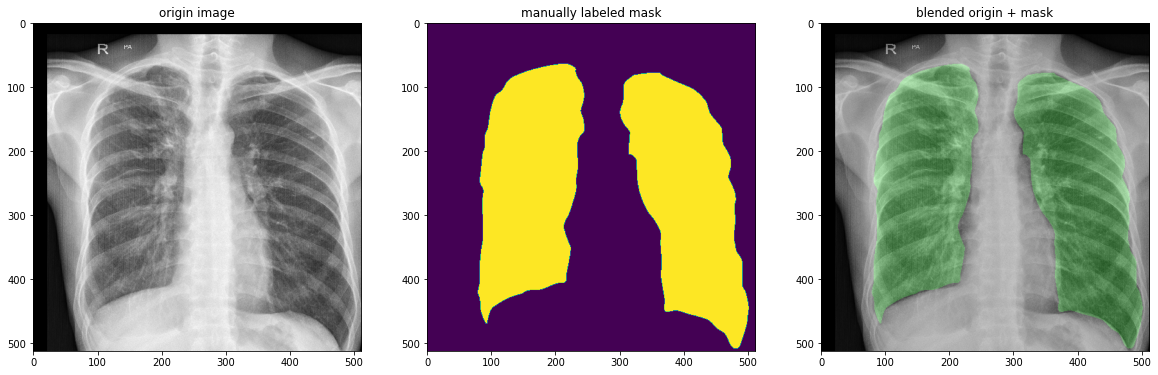

In [ ]:
idx = 1
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
pil_mask = torchvision.transforms.functional.to_pil_image(mask.float())

plt.subplot(1, 3, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 3, 2)
plt.title("manually labeled mask")
plt.imshow(np.array(pil_mask))

plt.subplot(1, 3, 3)
plt.title("blended origin + mask")
plt.imshow(np.array(blend(origin, mask)));

plt.savefig(images_folder / "data-example.png", bbox_inches='tight')

## Обучим модель

In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)
unet

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

## Задание 1

Используйте tensorboard для визуализации модели. Покажите структуру модели, обратите на размерности данных в промежуточных слоях.

Запустите код ниже. Если появившееся окно будет пустым -- **обновите его стрелочкой (↻)** в правом верхнем углу.

"Раскройте" графовое представление модели двойным кликом по ней. Исследуйте граф модели (можно перетаскивать область видимости мышкой, можно приближать/отдалять колесом).

* Как изменяется размерность данных на протяжении сети?

* Как устроены блоки энкодера, декодера и "центральный" блок?

**Важно!** В следующем задании мы будем обучать сеть. Это займет МНОГО времени даже при использовании GPU. Поэтому логичным шагом будет подготовить визуализацию сети в рамках этого задания, потом поставить ее обучаться во втором и вернуться к изучению её структуры сюда.





<img src="https://images.deepai.org/converted-papers/2004.10696/unet.png" alt="Drawing" width= "1000px;"/>

In [ ]:
# вспомогательный код для визуализации

import os
import shutil

# Helper method to run Tensorboard in Colab
def reinit_tensorboard(clear_log = True):
  # Directory for log files
  logs_base_dir = "runs"
  if clear_log:
    # Clear logs
    shutil.rmtree(logs_base_dir, ignore_errors = True)
    os.makedirs(logs_base_dir, exist_ok=True)
  # Colab magic
  %load_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter

reinit_tensorboard()
writer = SummaryWriter(comment = "unet")

dummy_input = torch.randn([1,1,512,512])
writer.add_graph(unet, dummy_input)
writer.flush()
writer.close()

In [ ]:
#unet(dummy_input)

Напишите здесь ваши выводы в свободной форме:

## Задание 2

Обучите модель. Выберите оптимизатор: SGD с momentum=0.9 или Adam. learning rate возьмите близкий к 0.0005

Дополните код обучения ниже: в выделенные места вставьте следующие команды:

* `unet.train()`
* `unet.eval()`
* `optimizer.zero_grad()`
* `optimizer.step()`

Обратите внимание, что модель обучается **долго**. Сначала проверьте работоспособность кода на 1 эпохе, потом **пересоздайте** модель и обучите на 4-8 эпохах.

Рассчитывайте свое время! Обучения сети на 6 эпох может занять ~45 минут.

In [ ]:
import torch.optim as optim

unet = unet.to(device)
optimizer = optim.Adam(unet.parameters(), lr=0.0005)

In [ ]:
epochs = 6

train_log_filename = "train-log.txt"
best_val_loss = np.inf
model_name = "unet.pt"

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()

    print("train phase")
    ##                ##
    # put some code here
    ##                ##
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        ##                ##
        # put some code here
        ##                ##

        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks)
        loss.backward()
        ##                ##
        # put some code here
        ##                ##

        train_loss += loss.item() * num
        print(".", end="")

    train_loss = train_loss / len(datasets['train'])
    print()


    print("validation phase")
    ##                ##
    # put some code here
    ##                ##
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks, outs.float()).item() * num
            val_dice += dice(masks, outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    print()


    end_t = time.time()
    spended_t = end_t - start_t

    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), models_folder / model_name)
            print("model saved")
            train_log_file.write("model saved\n")
        print()

train phase
...............................................................................................................................
validation phase
...............
epoch: 1/6, time: 192.56671237945557, train loss: 0.2290086709110162, 
val loss: 0.797607093526606, val jaccard: 0.5063773587084653, val dice: 0.6643689745350888
model saved

train phase
...............................................................................................................................
validation phase
...............
epoch: 2/6, time: 182.17875576019287, train loss: 0.12428306749922485, 
val loss: 0.10659788758085485, val jaccard: 0.8700288450508787, val dice: 0.927860583129682
model saved

train phase
...............................................................................................................................
validation phase
...............
epoch: 3/6, time: 179.40525245666504, train loss: 0.087812075177907, 
val loss: 0.1068340121654042, val jaccard: 0.86469850310108

### Отобразим сохраненные во время обучения метрики

<img src="https://camo.githubusercontent.com/52fabc35b61fb5d3dc936c3e192d62ae29f6b641dafcefc9484b39bdf593c178/68747470733a2f2f646174612e62696f6d6c2e72752f6874646f63732f636f75727365732f62696f6d6c2f6e657572616c5f6e6574776f726b732f6175746f656e636f646572732f696d672f6a6163636172645f616e645f646963655f716d2e706e67" alt="Drawing" width= "700px;"/>

In [ ]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [ ]:
torch.cuda.empty_cache()

### Пришло время оценить качество модели!

In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")

In [ ]:
model_name = "unet.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

In [ ]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase],
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin, mask, out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")

plt.savefig(images_folder / "obtained-results.png", bbox_inches='tight')
print()
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")

## Задание 3

Загрузите веса модели, обученной на 100 эпохах. Оцените качество предсказания численно и на тестовом наборе изображений.

In [ ]:
!wget https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/data/unet-6v.pt -O ./models/unet-6v.pt

In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")

model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval()

In [ ]:
# put your code here



In [ ]:
# put more code here

